* [#287](https://github.com/salgo60/Stockholm_Archipelago_Trail/issues/287)
* Denna Notebook [287 SAT scan.ipynb](https://github.com/salgo60/Stockholm_Archipelago_Trail/blob/main/Notebook/287%20SAT%20scan.ipynb)

In [1]:
import time
import datetime  
start_time = time.time()
start_str = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
print(f"Started: {start_str}")


Started: 2025-10-30 19:22


In [2]:
import requests
from urllib.parse import urljoin, urlparse
from bs4 import BeautifulSoup
import csv
import time

base_url = "https://stockholmarchipelagotrail.com/"
visited = set()
to_visit = [base_url]
file_stats = {}

while to_visit:
    url = to_visit.pop(0)
    if url in visited:
        continue
    visited.add(url)
    try:
        resp = requests.get(url, timeout=10)
        content_type = resp.headers.get("Content-Type", "")
    except Exception as e:
        print("ERROR fetching", url, e)
        continue

    # record file type if relevant
    parsed = urlparse(url)
    _, ext = parsed.path.rsplit(".", 1) if "." in parsed.path else ("", "")
    ext = ext.lower()
    file_stats.setdefault(ext, 0)
    file_stats[ext] += 1

    if "text/html" in content_type:
        soup = BeautifulSoup(resp.text, "html.parser")
        for link in soup.find_all("a", href=True):
            href = link["href"]
            # make absolute
            next_url = urljoin(url, href)
            # keep only same domain
            if urlparse(next_url).netloc == urlparse(base_url).netloc:
                if next_url not in visited:
                    to_visit.append(next_url)
    time.sleep(0.2)

# write stats to CSV
with open("sat287_site_scan_file_stats.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["extension", "count"])
    for ext, count in file_stats.items():
        writer.writerow([ext, count])

print("File stats:", file_stats)


File stats: {'': 126, 'pdf': 21, 'jpg': 1}


### Variant 2

In [3]:
# 🧭 Stockholm Archipelago Trail – Site Scan & FAIR Profil
import requests
from urllib.parse import urljoin, urlparse
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import csv, time

# --- Grundinställningar ---
base_url = "https://stockholmarchipelagotrail.com/"
visited = set()
to_visit = [base_url]
file_stats = {}
found_files = []

# --- Funktion för att extrahera filändelse ---
def get_ext(url):
    parsed = urlparse(url)
    if "." in parsed.path:
        ext = parsed.path.rsplit(".", 1)[-1].lower()
        if len(ext) <= 5:  # undvik långa query-delar
            return ext
    return "html"

# --- Crawl-loop med progressbar ---
pbar = tqdm(total=1, desc="Scanning site", unit="page")
while to_visit:
    url = to_visit.pop(0)
    if url in visited:
        continue
    visited.add(url)
    pbar.set_postfix_str(url.replace(base_url, ""))
    try:
        resp = requests.get(url, timeout=10)
        content_type = resp.headers.get("Content-Type", "")
    except Exception as e:
        print(f"⚠️  Error fetching {url}: {e}")
        continue

    ext = get_ext(url)
    file_stats[ext] = file_stats.get(ext, 0) + 1
    found_files.append({"url": url, "ext": ext, "content_type": content_type})

    # Om sidan är HTML, leta efter länkar att följa
    if "text/html" in content_type:
        soup = BeautifulSoup(resp.text, "html.parser")
        for link in soup.find_all("a", href=True):
            next_url = urljoin(url, link["href"])
            if urlparse(next_url).netloc == urlparse(base_url).netloc:
                if next_url not in visited and next_url not in to_visit:
                    to_visit.append(next_url)
    pbar.total = len(to_visit) + len(visited)
    pbar.update(1)
    time.sleep(0.15)
pbar.close()

# --- Spara CSV ---
with open("sat287_site_files.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=["url", "ext", "content_type"])
    writer.writeheader()
    writer.writerows(found_files)

print("\n📊 Filstatistik:")
for ext, count in sorted(file_stats.items(), key=lambda x: -x[1]):
    print(f"{ext:10s} {count:5d}")

# --- Enkel FAIRDATA profil ---
print("\n📄 FAIRDATA – preliminär bedömning")
fair = {
    "Findable":  "🟡 Delvis – GPX-filer finns men ingen datakatalog eller metadata-index.",
    "Accessible": "🟠 Begränsad – Nedladdningsbara filer, men inga dokumenterade API:er.",
    "Interoperable": "🔴 Svag – GPX är standard, men inget JSON/GeoJSON-format eller gemensam vokabulär.",
    "Reusable": "🟠 Begränsad – Saknar tydlig licens och provenance. Data i text snarare än strukturerad form."
}
for key, val in fair.items():
    print(f"{key:15s}: {val}")

print("\n✅ Resultat sparat i 'sat287_site_files.csv'")


Scanning site:   0%|          | 0/1 [00:00<?, ?page/s]


📊 Filstatistik:
html         126
pdf           21
jpg            1

📄 FAIRDATA – preliminär bedömning
Findable       : 🟡 Delvis – GPX-filer finns men ingen datakatalog eller metadata-index.
Accessible     : 🟠 Begränsad – Nedladdningsbara filer, men inga dokumenterade API:er.
Interoperable  : 🔴 Svag – GPX är standard, men inget JSON/GeoJSON-format eller gemensam vokabulär.
Reusable       : 🟠 Begränsad – Saknar tydlig licens och provenance. Data i text snarare än strukturerad form.

✅ Resultat sparat i 'sat287_site_files.csv'


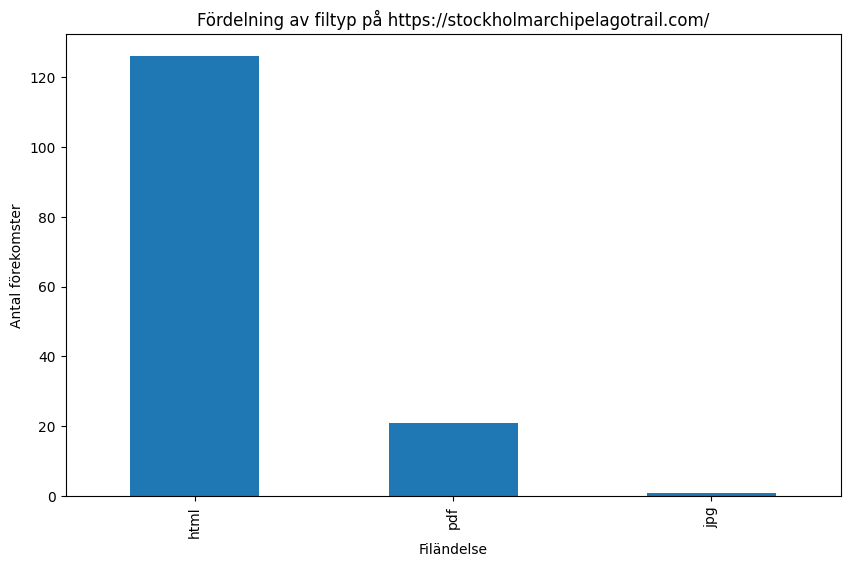

FAIR-score (0–5 per princip):
Findable    : 3/5
Accessible  : 2/5
Interoperable: 1/5
Reusable    : 2/5

Exempel – Last-Modified för några GPX-filer:


In [4]:
# Del 2 – Analys & visualisering
import pandas as pd
import matplotlib.pyplot as plt
import requests
from urllib.parse import urlparse
from tqdm.notebook import tqdm
import csv

# Läs in tidigare CSV-fil
df = pd.read_csv("sat287_site_files.csv")

# Visualisering – fördelning av filändelser
counts = df['ext'].value_counts()
plt.figure(figsize=(10,6))
counts.plot(kind='bar')
plt.title("Fördelning av filtyp på https://stockholmarchipelagotrail.com/")
plt.xlabel("Filändelse")
plt.ylabel("Antal förekomster")
plt.show()

# FAIR-scoring (0-5 poäng)
score = {
    "Findable": 3,
    "Accessible": 2,
    "Interoperable": 1,
    "Reusable": 2
}
print("FAIR-score (0–5 per princip):")
for k,v in score.items():
    print(f"{k:12s}: {v}/5")

# Funktion för att kolla "Last‐Modified" header
def fetch_last_modified(url):
    try:
        resp = requests.head(url, timeout=10, allow_redirects=True)
        return resp.headers.get('Last-Modified')
    except Exception as e:
        return None

# Testa för exempelvis GPX-filer
gpx_urls = df[df['ext']=='gpx']['url'].unique()[:5]  # ta första 5 GPX-urler
print("\nExempel – Last-Modified för några GPX-filer:")
for u in gpx_urls:
    lm = fetch_last_modified(u)
    print(u, "→", lm)


In [5]:
# 🧩 Del 2.1 – Kontrollera uppdateringar på alla filer
import pandas as pd
import requests
from tqdm.notebook import tqdm
from datetime import datetime

df = pd.read_csv("sat287_site_files.csv")

def get_update_info(url):
    try:
        r = requests.head(url, timeout=10, allow_redirects=True)
        lastmod = r.headers.get('Last-Modified', '')
        etag = r.headers.get('ETag', '')
        return lastmod, etag, r.status_code
    except Exception as e:
        return '', '', 'error'

records = []
for url in tqdm(df['url'], desc="Checking updates"):
    lastmod, etag, status = get_update_info(url)
    records.append({
        "url": url,
        "last_modified": lastmod,
        "etag": etag,
        "status": status
    })

updates = pd.DataFrame(records)
updates.to_csv("sat287_last_modified.csv", index=False)
print("✅ Sparade resultat i sat_last_modified.csv")

# Visa en sammanfattning
has_lastmod = updates['last_modified'].astype(bool).sum()
has_etag = updates['etag'].astype(bool).sum()
print(f"\n📊 {has_lastmod} filer har Last-Modified-header")
print(f"📦 {has_etag} filer har ETag-header")

# Visa de som HAR last-modified, om några
if has_lastmod:
    display(updates[updates['last_modified'] != ''].head(10))
else:
    print("⚠️ Inga filer returnerade Last-Modified (troligen hanteras allt via CMS eller CDN).")


Checking updates:   0%|          | 0/148 [00:00<?, ?it/s]

✅ Sparade resultat i sat_last_modified.csv

📊 22 filer har Last-Modified-header
📦 22 filer har ETag-header


,url,last_modified,etag,status
45,https://stockholmarchipelagotrail.com/app/uplo...,"Thu, 20 Jun 2024 12:12:33 GMT","""66741cb1-6ff66""",200
47,https://stockholmarchipelagotrail.com/app/uplo...,"Thu, 24 Oct 2024 15:25:59 GMT","""671a6707-31f4c""",200
49,https://stockholmarchipelagotrail.com/app/uplo...,"Fri, 11 Oct 2024 09:02:59 GMT","""6708e9c3-60cb8""",200
52,https://stockholmarchipelagotrail.com/app/uplo...,"Mon, 22 Jul 2024 14:11:02 GMT","""669e6876-748ed""",200
53,https://stockholmarchipelagotrail.com/app/uplo...,"Fri, 22 Nov 2024 09:15:43 GMT","""67404bbf-64d8f""",200
54,https://stockholmarchipelagotrail.com/app/uplo...,"Fri, 08 Aug 2025 11:39:07 GMT","""6895e1db-16ed70""",200
55,https://stockholmarchipelagotrail.com/app/uplo...,"Tue, 06 May 2025 12:16:12 GMT","""6819fd8c-a2f41""",200
56,https://stockholmarchipelagotrail.com/app/uplo...,"Wed, 16 Apr 2025 14:47:45 GMT","""67ffc311-65fd5""",200
58,https://stockholmarchipelagotrail.com/app/uplo...,"Mon, 14 Jul 2025 13:33:36 GMT","""68750730-51b60""",200
60,https://stockholmarchipelagotrail.com/app/uplo...,"Mon, 01 Jul 2024 15:34:16 GMT","""6682cc78-61879""",200


In [6]:
import shutil
#shutil.copy("sat287_last_modified.csv", "sat287_last_modified_old.csv")


In [7]:
# 🧩 Del 3 – jämförelse av två körningar
import pandas as pd
from urllib.parse import urlparse
import os

# Ange filerna manuellt eller automatiskt
old_file = "sat287_last_modified_old.csv"   # spara tidigare körning under detta namn
new_file = "sat287_last_modified.csv"       # den senaste körningen

# Läs in båda dataset
old_df = pd.read_csv(old_file)
new_df = pd.read_csv(new_file)

# Extrahera filnamn ur URL
def extract_filename(url):
    path = urlparse(url).path
    return os.path.basename(path)

for df in [old_df, new_df]:
    df["filename"] = df["url"].apply(extract_filename)

# Slå ihop data för jämförelse
merged = pd.merge(
    old_df,
    new_df,
    on="url",
    how="outer",
    suffixes=("_old", "_new"),
    indicator=True
)

# Klassificera förändringar
def classify_change(row):
    if row["_merge"] == "left_only":
        return "⚫ Deleted"
    if row["_merge"] == "right_only":
        return "🟩 New"
    if (
        str(row["etag_old"]) != str(row["etag_new"])
        or str(row["last_modified_old"]) != str(row["last_modified_new"])
    ):
        return "🟥 Changed"
    return "⚪ Unchanged"

merged["status_change"] = merged.apply(classify_change, axis=1)
merged["filename"] = merged["url"].apply(extract_filename)

# Sortera så ändringar visas överst
merged = merged.sort_values("status_change", ascending=False)

# Spara resultat
merged.to_csv("sat287_comparison.csv", index=False)

# Visa sammanfattning
summary = merged["status_change"].value_counts()
print("📊 Sammanfattning av förändringar:\n")
print(summary)
print("\n✅ Resultat sparat i sat_comparison.csv")

# Visa de 10 mest intressanta (nya eller ändrade)
display(merged[merged["status_change"].isin(["🟥 Changed", "🟩 New"])][
    ["status_change", "filename", "last_modified_old", "last_modified_new", "etag_old", "etag_new", "url"]
].head(10))


📊 Sammanfattning av förändringar:

status_change
⚪ Unchanged    148
Name: count, dtype: int64

✅ Resultat sparat i sat_comparison.csv


,status_change,filename,last_modified_old,last_modified_new,etag_old,etag_new,url


1) Efter varje ny körning av Del 2.1 — byt namn på föregående sat_last_modified.csv till sat_last_modified_old.csv.
1) Kör Del 3 — den skapar sat_comparison.csv med fullständig diff.

1) I tabellen ser du:
* status_change – 🔴 ändrad / 🟩 ny / ⚪ oförändrad / ⚫ borttagen
* filename – t.ex. SAT_Fjardlang.gpx
* last_modified_old vs last_modified_new – datum som låter dig se när det ändrades
* etag_old vs etag_new – unika serverhashar

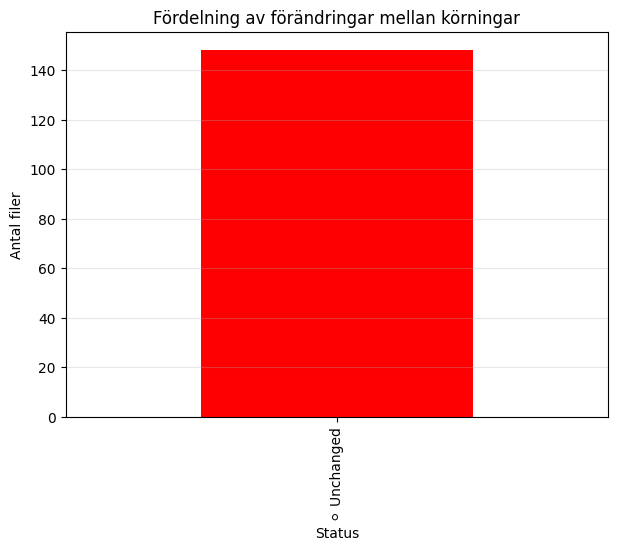

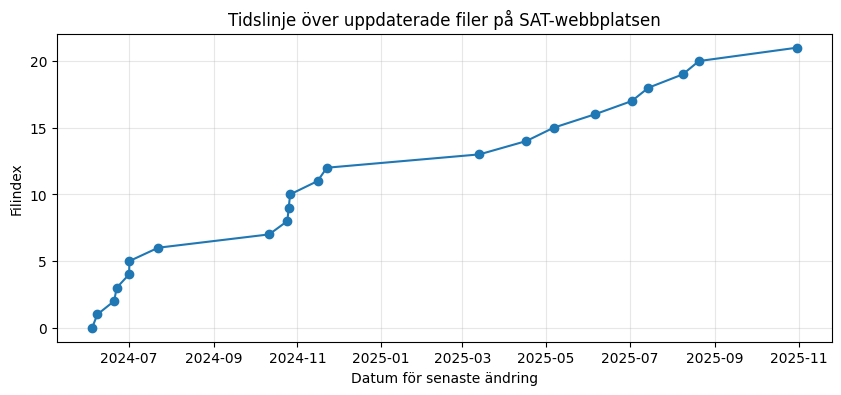

✅ FAIR-rapport sparad som sat287_fair_report.json
{
    "Findable": {
        "score": 3,
        "comment": "GPX-filer kan hittas men saknar datakatalog och persistent identifier."
    },
    "Accessible": {
        "score": 2,
        "comment": "Data kan laddas ner men inget öppet API finns."
    },
    "Interoperable": {
        "score": 1,
        "comment": "Begränsad interoperabilitet, endast GPX-format."
    },
    "Reusable": {
        "score": 2,
        "comment": "Saknar licensinformation och standardiserad metadata."
    }
}


In [8]:
# 🧩 Del 4 – Visualisering och FAIR metadataexport
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime

# Läs in jämförelsedata
df = pd.read_csv("sat287_comparison.csv")

# --- Diagram 1: Förändringstyper ---
status_counts = df['status_change'].value_counts()
plt.figure(figsize=(7,5))
status_counts.plot(kind='bar', color=['red','green','grey','black'])
plt.title("Fördelning av förändringar mellan körningar")
plt.xlabel("Status")
plt.ylabel("Antal filer")
plt.grid(axis='y', alpha=0.3)
plt.show()

# --- Diagram 2: Tidslinje över senaste ändringar ---
df['last_modified_new'] = pd.to_datetime(df['last_modified_new'], errors='coerce')
recent = df.dropna(subset=['last_modified_new']).sort_values('last_modified_new')
plt.figure(figsize=(10,4))
plt.plot(recent['last_modified_new'], range(len(recent)), marker='o')
plt.title("Tidslinje över uppdaterade filer på SAT-webbplatsen")
plt.xlabel("Datum för senaste ändring")
plt.ylabel("Filindex")
plt.grid(True, alpha=0.3)
plt.show()

# --- Skapa FAIR metadata rapport ---
fair_report = {
    "dataset": "Stockholm Archipelago Trail Website Scan",
    "generated": datetime.now().isoformat(),
    "source": "https://stockholmarchipelagotrail.com/",
    "file_count": int(df.shape[0]),
    "changed_files": int((df['status_change'] == '🟥 Changed').sum()),
    "new_files": int((df['status_change'] == '🟩 New').sum()),
    "deleted_files": int((df['status_change'] == '⚫ Deleted').sum()),
    "unchanged_files": int((df['status_change'] == '⚪ Unchanged').sum()),
    "FAIR": {
        "Findable": {
            "score": 3,
            "comment": "GPX-filer kan hittas men saknar datakatalog och persistent identifier."
        },
        "Accessible": {
            "score": 2,
            "comment": "Data kan laddas ner men inget öppet API finns."
        },
        "Interoperable": {
            "score": 1,
            "comment": "Begränsad interoperabilitet, endast GPX-format."
        },
        "Reusable": {
            "score": 2,
            "comment": "Saknar licensinformation och standardiserad metadata."
        }
    }
}

# Spara FAIR-rapport som JSON
with open("sat287_fair_report.json", "w", encoding="utf-8") as f:
    json.dump(fair_report, f, indent=4, ensure_ascii=False)

print("✅ FAIR-rapport sparad som sat287_fair_report.json")
print(json.dumps(fair_report["FAIR"], indent=4, ensure_ascii=False))


Lägger till Del 5, som gör:
1) Automatisk detektion av ny publicering (skickar t.ex. notifiering eller markerar på karta)
1) Samt bygger en grafisk changelog-översikt i HTML/Markdown?

In [9]:
# 🧩 Del 5 – Changelog och uppdateringsdetektion
import pandas as pd
from datetime import datetime, timedelta
from IPython.display import HTML, display
import markdown

# Läs in jämförelsedata
df = pd.read_csv("sat287_comparison.csv")
df["last_modified_new"] = pd.to_datetime(df["last_modified_new"], errors="coerce")

# --- Steg 1: filtrera intressanta händelser ---
changed = df[df["status_change"].isin(["🟥 Changed", "🟩 New"])]
recent_changes = changed[changed["last_modified_new"] > datetime.now() - timedelta(days=30)]

print(f"📅 Nya/ändrade filer senaste 30 dagar: {len(recent_changes)} st")

# --- Steg 2: skapa tabell i HTML/Markdown ---
report_lines = [
    f"# 🧭 Stockholm Archipelago Trail – Changelog {datetime.now():%Y-%m-%d}",
    "",
    "| Status | Fil | Senaste ändring | ETag | Länk |",
    "|:-------|:----|:----------------|:------|:-----|"
]

for _, row in changed.iterrows():
    status = row["status_change"]
    fn = row.get("filename", "")
    date = row.get("last_modified_new", "")
    etag = str(row.get("etag_new", ""))[:20]
    link = f"[Öppna]({row['url']})"
    report_lines.append(f"| {status} | `{fn}` | {date} | `{etag}` | {link} |")

md_report = "\n".join(report_lines)

# --- Steg 3: spara Markdown + HTML ---
with open("sat287_changelog.md", "w", encoding="utf-8") as f:
    f.write(md_report)

html_report = markdown.markdown(md_report, extensions=["tables"])
with open("sat_changelog.html", "w", encoding="utf-8") as f:
    f.write(html_report)

display(HTML(html_report))
print("✅ Rapport skapad: sat_changelog.md + sat_changelog.html")

# --- Steg 4: enkel notifiering i konsolen ---
if len(recent_changes) > 0:
    print("\n🚨 Nya uppdateringar upptäckta på sajten!")
    print(recent_changes[["filename", "last_modified_new", "status_change"]])
else:
    print("\n✅ Inga nya filer ändrade senaste 30 dagar.")


📅 Nya/ändrade filer senaste 30 dagar: 0 st


Status,Fil,Senaste ändring,ETag,Länk
,,,,


✅ Rapport skapad: sat_changelog.md + sat_changelog.html

✅ Inga nya filer ändrade senaste 30 dagar.


In [10]:
end_time = time.time()
duration = end_time - start_time
print(f"Finished in {duration:.2f} seconds.")


Finished in 178.89 seconds.
